In [4]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy

In [8]:
def pi_l(p, vs, i, dist, supp):
    """lower bound for profits"""
    return vs*dist.cdf(p)**i + i*p*(1-dist.cdf(p))*dist.cdf(p)**(i-1)


def pi_u(p, vs, i, dist, supp):
    """upper bound for profits"""
    integrand = lambda v: i*(i-1)*(1-dist.cdf(v))*v*dist.cdf(v)**(i-2)*dist.pdf(v)
    surplus = []
    for q in p:
        surplus.append( scipy.integrate.quad(integrand, q, supp[1])[0] )
    return pi_l(p, vs, i, dist, supp) + np.array(surplus)

In [9]:
def pi_opt(vs, i, dist, supp):
    """argmax of lower bound"""
    obj = lambda p: -pi_l(p, vs, i, dist, supp)
    result = scipy.optimize.minimize(obj, sum(supp)/2.)
    return result.x, -1*obj(result.x)


def pi_est(vs, i, dist, supp):
    """calculate the """
    argmax, maxim = pi_opt(vs, i, dist, supp)
   
    obj = lambda p:(pi_u(p, vs, i, dist, supp) - maxim)**2

    bnds1 = [(supp[0],argmax)]
    result1 = scipy.optimize.minimize(obj, argmax*.9, bounds=bnds1 )
    
    bnds2 = [(argmax,supp[1])]
    result2 = scipy.optimize.minimize(obj, argmax*1.1, bounds=bnds2 )

    return np.concatenate([result1.x, result2.x])

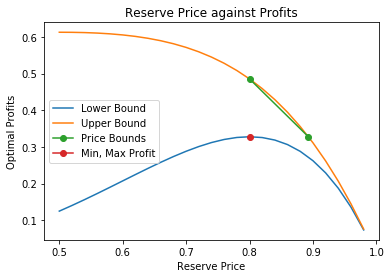

In [20]:
#overall bounds on profit
support = np.arange(.5,1.0,.02)
ub = pi_u(support, 0, 4, scipy.stats.uniform, (0,1))
lb = pi_l(support, 0, 4, scipy.stats.uniform, (0,1))

plt.plot(support, lb, label='Lower Bound')
plt.plot(support, ub, label='Upper Bound')

#bounds on reserve price
argmax, maxim = pi_opt(0, 4, scipy.stats.uniform, (0,1))
p_bnds = pi_est(0, 4, scipy.stats.uniform, (0,1))
pi_bnds = pi_u(p_bnds, 0, 4, scipy.stats.uniform, (0,1))

plt.plot(p_bnds, pi_bnds, label='Price Bounds',marker='o')
plt.plot(argmax, maxim, label='Min, Max Profit',marker='o')


#make it pretty
plt.xlabel('Reserve Price')
plt.ylabel('Optimal Profits')
plt.title('Reserve Price against Profits')
plt.legend()
plt.show()